In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
import math
from PIL import ImageFile
from torchvision.transforms import InterpolationMode
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

In [4]:
#FORM A LIST OF LAT LONG COORDINATES BASED ON ALPHABETICALLY SORTED AREA OF INTEREST FILENAMES

train_directory = '/local/home/stuff/datasets/Challenge_7/test_public/'
#print(sorted(os.listdir(train_directory)))
sorted_coordinates = []
area_images = []
for area_of_interest in sorted(os.listdir(train_directory)):
    
    f = os.path.join(train_directory, area_of_interest,'labels/')
    buildings_geojson = glob.glob(f+'*Buildings*')[2]
    temp = open(buildings_geojson)
    geojson_dict = json.load(temp)
    #print(area_of_interest)
    #print(buildings_geojson)
    #print(geojson_dict['features'][0]['geometry']['coordinates'][0][0])
    sorted_coordinates.append(geojson_dict['features'][0]['geometry']['coordinates'][0][0])
    
    g = os.listdir(os.path.join(train_directory, area_of_interest,'images_masked/'))
    area_images.append(g)

print(sorted_coordinates)
print(len(area_images[0]))




IndexError: list index out of range

In [8]:
geolocator = Nominatim(user_agent="geoapiExercises")
labels = []

for area in sorted_coordinates:
    
    lat = str(area[1])
    long = str(area[0])
    coordinates = lat+','+long
    #print(coordinates)
    
    location = geolocator.reverse(coordinates)
    address = location.raw['address']
    #print(address)
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    
    labels.append([city,state,country])
    
    #print(location)

print(labels)

[['', 'California', 'United States'], ['', 'California', 'United States'], ['San Diego', 'California', 'United States'], ['Meridian', 'Idaho', 'United States'], ['Las Vegas', 'Nevada', 'United States'], ['Lehi', 'Utah', 'United States'], ['', 'New Mexico', 'United States'], ['', 'Estado de México', 'México'], ['Bentonville', 'Arkansas', 'United States'], ['', 'Louisiana', 'United States'], ['Atlanta', 'Georgia', 'United States'], ['Port Saint Lucie', 'Florida', 'United States'], ['Panamá', 'Panamá', 'Panamá'], ['', 'North Carolina', 'United States'], ['Portmore', '', 'Jamaica'], ['Forks Township', 'Pennsylvania', 'United States'], ['San Sebastián', 'Cusco', 'Perú'], ['Calama', 'Región de Antofagasta', 'Chile'], ['Manaus', 'Amazonas', 'Brasil'], ['', 'São Paulo', 'Brasil'], ['Dakar', 'Région de Dakar', 'Sénégal'], ['Tindouf ⵜⵉⵏⴷⵓⴼ تندوف', 'Tindouf ⵜⵉⵏⴷⵓⴼ تندوف', 'Algérie / ⵍⵣⵣⴰⵢⴻⵔ / الجزائر'], ['', 'England', 'United Kingdom'], ['', 'Ashanti Region', 'Ghana'], ['Dartford', 'England', 'U

In [9]:
#CONCATENATE ALL THE 24 IMAGES PER LOCATION WITH THEIR LABELS TO CREATE LABELS.CSV

image_id_and_labels = np.zeros((1,4))
label_counter = 0

for temporal_images in area_images:
    num_labels = len(temporal_images)
    current_label = labels[label_counter]
    #print(2*[label])
    #print(temporal_images)
    temporal_images_arr = np.array(temporal_images)
    labels_arr = np.array(num_labels*[current_label])
    #print('Temporal:', temporal_images_arr.shape)
    #print('Labels:', labels_arr.shape)
    appended_array = np.column_stack( (temporal_images_arr, labels_arr ) )
    #print(appended_array)
    label_counter += 1
    image_id_and_labels = np.row_stack( (image_id_and_labels,appended_array) )
    
image_id_and_labels[0,0] = 'Image_id'
image_id_and_labels[0,1] = 'City'
image_id_and_labels[0,2] = 'State'
image_id_and_labels[0,3] = 'Country'

print(image_id_and_labels)

np.savetxt("ids_and_labels.csv", image_id_and_labels, delimiter=",", fmt='%s')



[['Image_id' 'City' 'State' 'Country']
 ['global_monthly_2019_05_mosaic_L15-0331E-1257N_1327_3160_13.tif' ''
  'California' 'United States']
 ['global_monthly_2018_09_mosaic_L15-0331E-1257N_1327_3160_13.tif' ''
  'California' 'United States']
 ...
 ['global_monthly_2019_01_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 'Australia']
 ['global_monthly_2018_12_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 'Australia']
 ['global_monthly_2019_06_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' 'Australia']]


In [13]:
#ENCODE THE COUNTRY LABELS SO THAT DATASET CAN READ THEM As TENSORS
label_encoder = LabelEncoder()
image_id_and_labels_encoded = image_id_and_labels.copy()
label_encoder.fit(image_id_and_labels_encoded[1:,3])
encoded_countries = label_encoder.transform(image_id_and_labels_encoded[1:,3])
#print(encoded_countries)
image_id_and_labels_encoded[1:,3] = encoded_countries
print(image_id_and_labels_encoded)
np.savetxt("ids_and_labels_encoded.csv", image_id_and_labels_encoded, delimiter=",", fmt='%s')

[['Image_id' 'City' 'State' 'Country']
 ['global_monthly_2019_05_mosaic_L15-0331E-1257N_1327_3160_13.tif' ''
  'California' '18']
 ['global_monthly_2018_09_mosaic_L15-0331E-1257N_1327_3160_13.tif' ''
  'California' '18']
 ...
 ['global_monthly_2019_01_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' '1']
 ['global_monthly_2018_12_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' '1']
 ['global_monthly_2019_06_mosaic_L15-1848E-0793N_7394_5018_13.tif'
  'Melbourne' 'Victoria' '1']]


In [14]:
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None):
        
        self.img_ids_labels = pd.read_csv("ids_and_labels_encoded.csv", header=1) #SINCE NO STRINGS ALLOWED!!!!
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/train'
        self.transform = torchvision.transforms.Resize((1023,1023))   #OTHERWISE SOME IMAGES 1024, SOME 1023!!!
        
    def __getitem__(self, idx):
        
        image_id = self.img_ids_labels.iloc[idx, 0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 3]))
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
            #label = self.target_transform(label)
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

/local/home/bsoyuer/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['Jamaica']
torch.Size([4, 1023, 1023])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


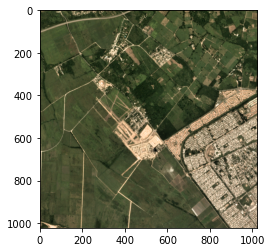

In [29]:
dataset = SN7Dataset()
first_data = dataset[345]
img, label = first_data
plt.imshow(img.permute(1,2,0))     #OTHER WAY TO PLOT????????
print(label_encoder.inverse_transform(label.detach().reshape(-1,1)))
print(img.shape)
print(type(img))
print(type(label))

torch.Size([6, 4, 1023, 1023])
torch.Size([6])
['مصر']
['Россия']
['India']
['السودان']
['Sénégal']
['中国']


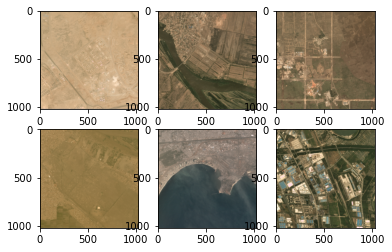

In [30]:
dataloader = DataLoader(dataset=dataset, batch_size = 6, shuffle = True)
dataiter = iter(dataloader)
data = dataiter.next()
imgs, labels = data
print(imgs.shape)
print(labels.shape)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.transpose(imgs[i]))
    print(label_encoder.inverse_transform(labels[i].detach().reshape(-1,1)))
plt.show()
    


In [35]:
#num_epochs = 2
#total_samples = len(dataset)
#n_iterations = math.ceil(total_samples/6)
#print(total_samples, n_iterations)

#for epoch in range(num_epochs):
#    for i, (inputs, labels) in enumerate(dataloader):
#        if (i+1)%5 == 0:
#            print(f'epoch{epoch+1}/{num_epochs}, step{i+1}/{n_iterations}, inputs{inputs.shape}')

for i, (inputs, labels) in enumerate(dataloader):
    if inputs.shape[1] == 3:
        print(f'inputs{inputs.shape}')
        print(i)